In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_original_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_original_all_features_motor_vibration_x\features"
targetFolderSIZA = r"H:\Extracted_Features\SIZA\SIZA_original_all_features\features"
normalization_method = "z_score"

In [2]:
experiment_name = "original_data_analysis_binary_best_features"
project_name="original_data_analysis_binary_best_features",
run_name="original_data_analysis_binary_best_features"
domain="all"

domains_to_use = ['time', 'frequency', 'time-frequency']

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=False

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def select_features_by_domain(domains: list, available_features: dict = None) -> list:
    """
    Selects a list of features based on the specified domains.

    Args:
        domains: A list of domain names (e.g., ['time', 'frequency']).
        available_features: A dictionary mapping domain names (keys) to 
                            lists of features (values). If None, uses a 
                            default dictionary.

    Returns:
        A flat list of all selected features.
    """
    # Define the complete feature set structure
    if available_features is None:
        available_features = {
            'time': ['rms', 'std', 'crest', 'energy', 'entropy'],
            'frequency': ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness'],
            # Assuming 'Time-Frequency' is referred to by a simpler domain name, 
            # or you can keep the full name
            'time-frequency': ['meanWavelet', 'varWavelet', 'entropyWavelet', 'entropySpectrogram']
        }

    selected_features = []
    
    # Iterate over the requested domains and extend the list
    for domain in domains:
        # Convert domain to lowercase for case-insensitive matching
        domain_key = domain.lower().replace('_', '-').strip()
        
        if domain_key in available_features:
            selected_features.extend(available_features[domain_key])
        else:
            print(f"Warning: Domain '{domain}' not recognized in available features.") # Optional warning

    # Return only unique features in case of overlap (though unlikely here)
    return list(set(selected_features))

In [6]:
features_to_include = select_features_by_domain(domains=domains_to_use)

In [7]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [8]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [9]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [10]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [11]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [12]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [13]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [14]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [15]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 161 files into a DataFrame with shape (200093, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['rms', 'std', 'varWavelet', 'crest', 'spectral_entropy', 'spectral_skewness', 'meanWavelet', 'entropyWavelet', 'entropySpectrogram', 'entropy', 'meanFreq', 'energy', 'medianFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (200093, 14)


In [16]:
df_SIZA = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['rms', 'std', 'varWavelet', 'crest', 'spectral_entropy', 'spectral_skewness', 'meanWavelet', 'entropyWavelet', 'entropySpectrogram', 'entropy', 'meanFreq', 'energy', 'medianFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 14)


In [17]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 36 files into a DataFrame with shape (53928, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['rms', 'std', 'varWavelet', 'crest', 'spectral_entropy', 'spectral_skewness', 'meanWavelet', 'entropyWavelet', 'entropySpectrogram', 'entropy', 'meanFreq', 'energy', 'medianFreq']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (53928, 14)


In [18]:
combined_df = pd.concat([df_HBK, df_SIZA, df_MCC5], ignore_index=True)

In [19]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [20]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [21]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [22]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [23]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,5973
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(246359, 14)"
5,Transformed data shape,"(246359, 14)"
6,Transformed train set shape,"(172451, 14)"
7,Transformed test set shape,"(73908, 14)"
8,Numeric features,13
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [24]:
experiment.y_test

133243    damaged
229817    damaged
184743    damaged
287277    damaged
19917     healthy
           ...   
264650    damaged
45809     damaged
196101    damaged
193312    damaged
102266    damaged
Name: Label, Length: 73908, dtype: category
Categories (2, object): ['damaged', 'healthy']

## Add aditional metrics

In [25]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [26]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001985687F2E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001985687F...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001985687F...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [27]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [28]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.9643,0.9905,0.9643,0.9640,0.9639,0.8953,0.8961,0.9374,0.0357,0.8486,0.0952
1,0.9683,0.9915,0.9683,0.9681,0.9680,0.9074,0.9080,0.9453,0.0317,0.8652,0.0898
2,0.9666,0.9907,0.9666,0.9663,0.9663,0.9024,0.9030,0.9424,0.0334,0.8584,0.0941
3,0.8046,0.6872,0.8046,0.7936,0.7975,0.4025,0.4056,0.6885,0.1954,0.3550,6.8667
4,0.8328,0.7862,0.8328,0.8400,0.8358,0.5392,0.5405,0.7803,0.1672,0.4799,5.7143
5,0.9682,0.9917,0.9682,0.9680,0.9678,0.9069,0.9076,0.9442,0.0318,0.8644,0.0886
6,0.9669,0.9914,0.9669,0.9667,0.9666,0.9034,0.9040,0.9425,0.0331,0.8596,0.0916
7,0.9660,0.9909,0.9660,0.9658,0.9656,0.9002,0.9012,0.9392,0.0340,0.8551,0.0975
8,0.9002,0.8836,0.9002,0.9030,0.9014,0.7209,0.7216,0.8692,0.0998,0.6473,2.7317


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/07 17:10:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [29]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,spectral_skewness,6027
1,crest,5719
2,entropyWavelet,5357
3,medianFreq,4894
4,meanFreq,4715
5,meanWavelet,4401
6,entropySpectrogram,4037
7,spectral_entropy,3980
8,varWavelet,3937
9,entropy,3887


In [31]:
add_top_features(lightgbm_top_features, top_n=3)

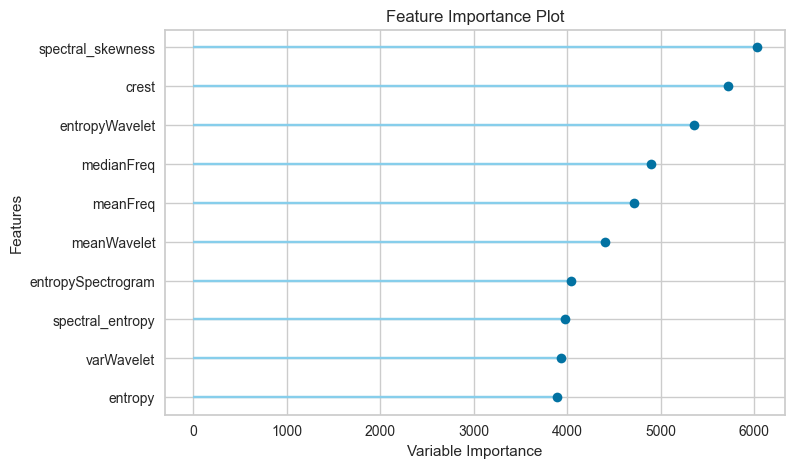

In [32]:
plot_model(lightgbm, plot='feature')

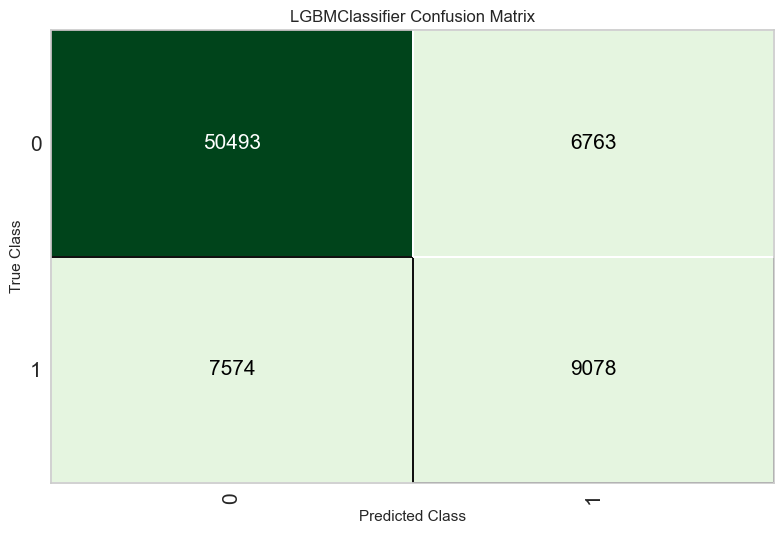

In [33]:
plot_model(lightgbm, plot='confusion_matrix')

In [34]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.8110,0.7156,0.8110,0.8070,0.8088,0.4467,0.4470,0.7185,0.1890,0.3961,6.3379


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [35]:
predictions_lightgbm

,rms,std,varWavelet,crest,spectral_entropy,spectral_skewness,meanWavelet,entropyWavelet,entropySpectrogram,entropy,meanFreq,energy,medianFreq,Label,prediction_label,prediction_score
93960,-0.492250,-0.515631,-0.275192,-0.595294,-0.464649,0.662564,-0.548131,0.169895,-0.156178,0.184032,-1.250423,-0.237836,-1.624495,damaged,damaged,1.0000
371,-0.589200,-0.621327,-0.276436,-0.137891,-0.482752,-0.413348,-0.715625,0.164535,-0.156183,0.181996,0.700811,-0.240687,1.582892,healthy,healthy,1.0000
33266,-0.590345,-0.622554,-0.276412,0.162632,-0.482801,0.857047,-0.726618,0.164418,-0.156183,0.181980,-0.071259,-0.240701,-0.063264,healthy,healthy,1.0000
238774,-0.136916,-0.127309,-0.210708,0.591589,-0.255165,-0.833513,-0.078935,0.202637,-0.155680,0.186596,-0.543695,-0.199561,-0.242809,damaged,damaged,1.0000
210317,-0.435811,-0.453998,-0.266166,-0.224380,-0.445249,-0.970789,-0.522627,0.174123,-0.156153,0.185095,-0.584476,-0.234678,-0.223067,damaged,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241132,-0.427159,-0.444468,-0.264591,0.946953,-0.436347,-0.543786,-0.530413,0.173715,-0.156126,0.184907,-0.542780,-0.234096,-0.229193,damaged,damaged,1.0000
214791,-0.406114,-0.421478,-0.262673,0.859693,-0.428352,-0.330569,-0.481127,0.175848,-0.156096,0.185382,-0.575204,-0.232573,-0.216777,damaged,damaged,0.9893
165165,0.188437,0.228228,-0.108072,2.730115,0.105598,-2.297781,0.267979,0.193819,-0.155000,0.156779,1.900277,-0.126170,1.888254,damaged,damaged,1.0000
217690,0.164117,0.201626,-0.105311,-0.162111,0.050038,-0.470341,0.351942,0.204984,-0.151695,0.170050,0.181994,-0.132923,-0.199653,damaged,damaged,1.0000


In [36]:
get_incorrect_predictions(predictions_lightgbm)

,rms,std,varWavelet,crest,spectral_entropy,spectral_skewness,meanWavelet,entropyWavelet,entropySpectrogram,entropy,meanFreq,energy,medianFreq,Label,prediction_label,prediction_score
16,-0.590913,-0.623379,-0.276468,0.810754,-0.482675,-0.837151,-0.718577,0.164459,-0.156183,0.181971,0.883688,-0.240708,0.985852,healthy,damaged,1.0000
258524,-0.602333,-0.637307,-0.276646,0.949561,-0.483689,0.343072,-0.734626,0.164046,-0.156183,0.181825,-1.784974,-0.240823,-1.315493,healthy,damaged,1.0000
14904,-0.616454,-0.655989,-0.276756,-1.356759,-0.484494,1.535372,-0.766810,0.163689,-0.156183,0.181710,-2.220697,-0.240903,-1.687100,healthy,damaged,1.0000
225615,-0.422542,-0.439494,-0.263346,1.068051,-0.438113,0.093645,-0.549108,0.173638,-0.156121,0.185135,-0.507703,-0.233775,-0.226039,damaged,healthy,1.0000
284123,-0.103334,-0.090598,-0.194134,-0.857306,-0.226782,1.158653,-0.116602,0.195797,-0.154956,0.187342,-0.248840,-0.193682,-0.214504,damaged,healthy,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282179,-0.434803,-0.452872,-0.265852,0.621108,-0.437211,0.093887,-0.527951,0.174266,-0.156134,0.185092,-0.586060,-0.234611,-0.224066,damaged,healthy,1.0000
6607,-0.482263,-0.504485,-0.270283,-1.490078,-0.462917,1.119532,-0.604374,0.170918,-0.156173,0.184481,0.953232,-0.237358,0.882884,healthy,damaged,1.0000
228293,-0.445842,-0.464968,-0.266916,0.025776,-0.445406,-0.529789,-0.548086,0.173333,-0.156154,0.185057,-0.502226,-0.235320,-0.215242,damaged,healthy,1.0000
83458,-0.423229,-0.440014,-0.265575,-0.781936,-0.439763,0.088521,-0.481146,0.177835,-0.156163,0.185672,0.510044,-0.233823,0.986533,damaged,healthy,1.0000


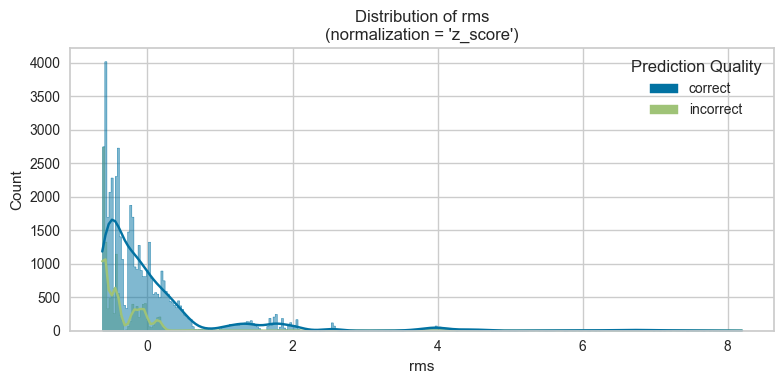

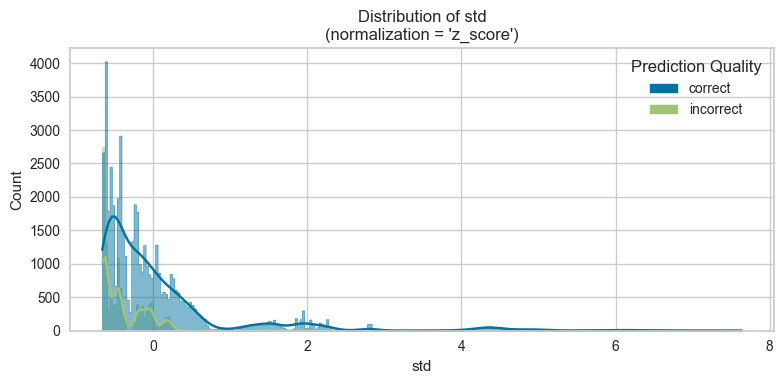

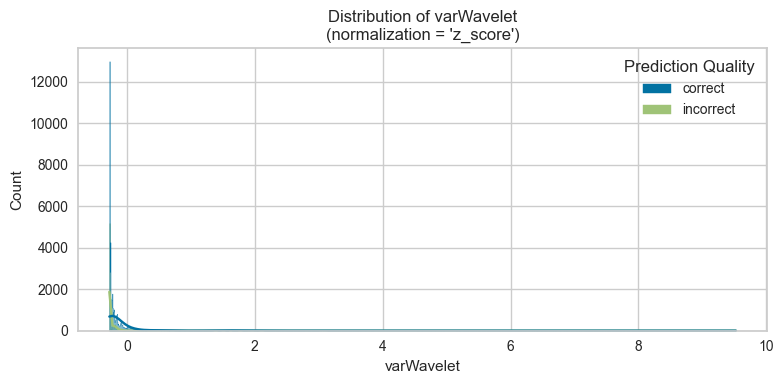

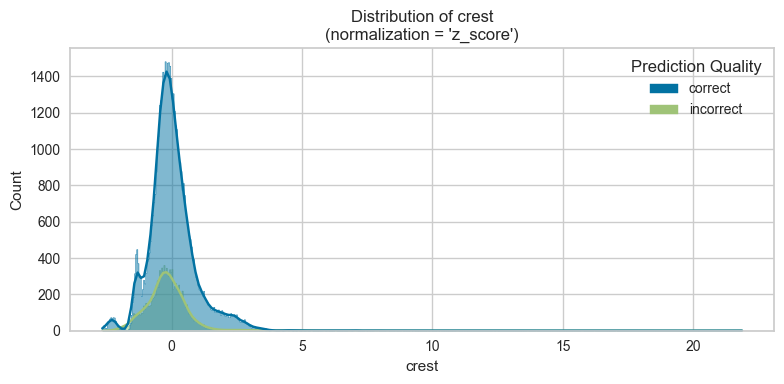

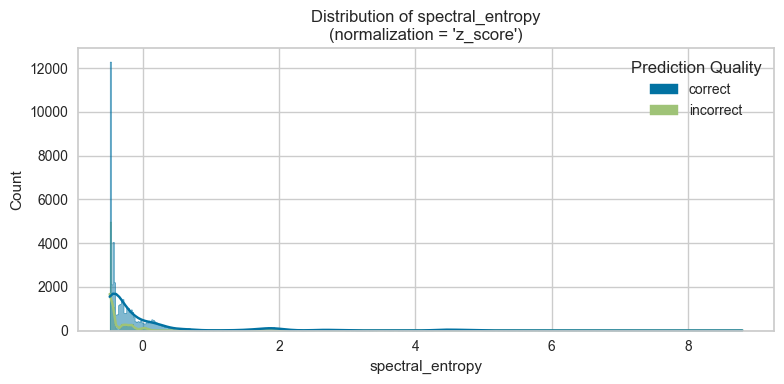

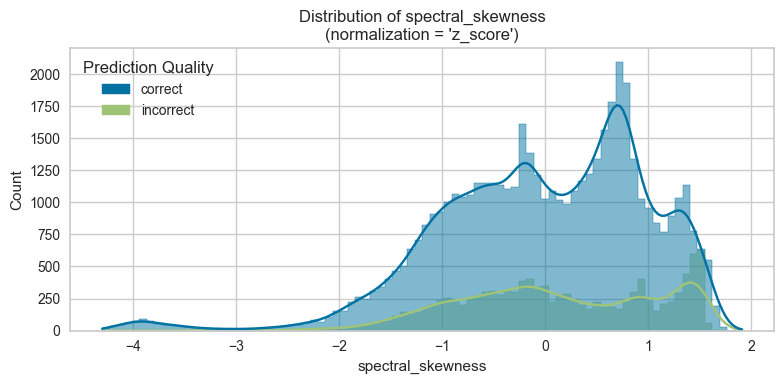

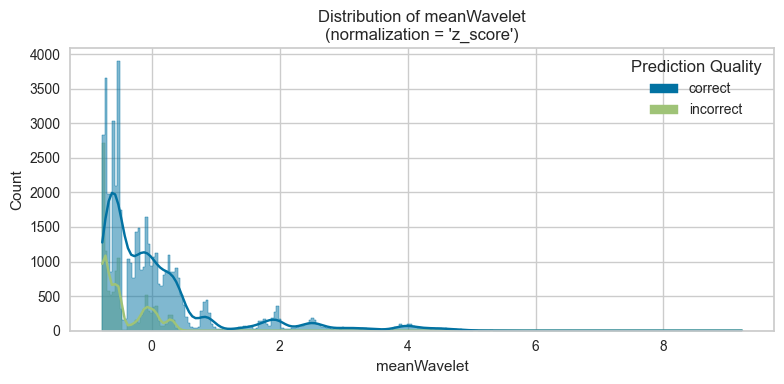

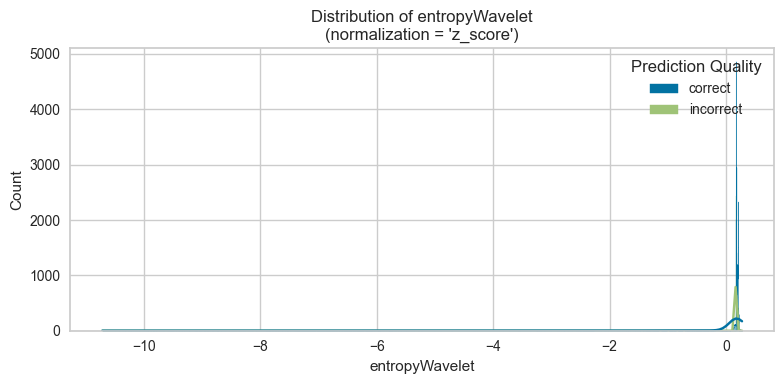

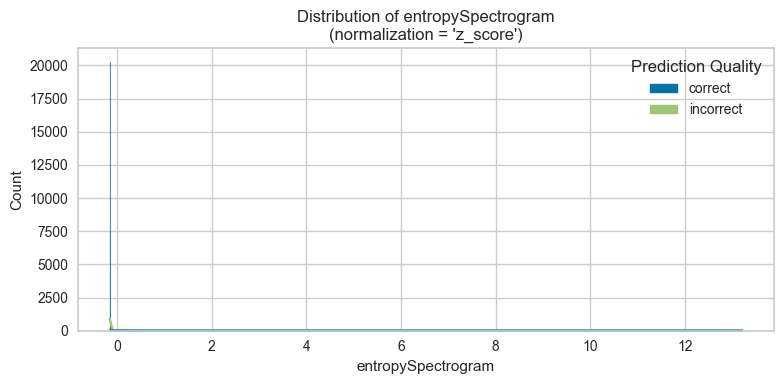

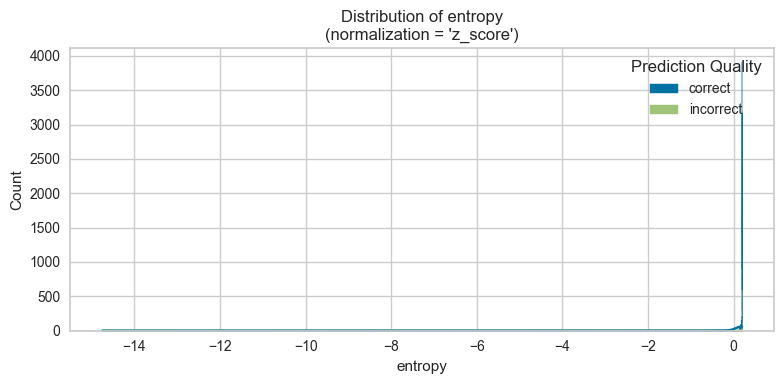

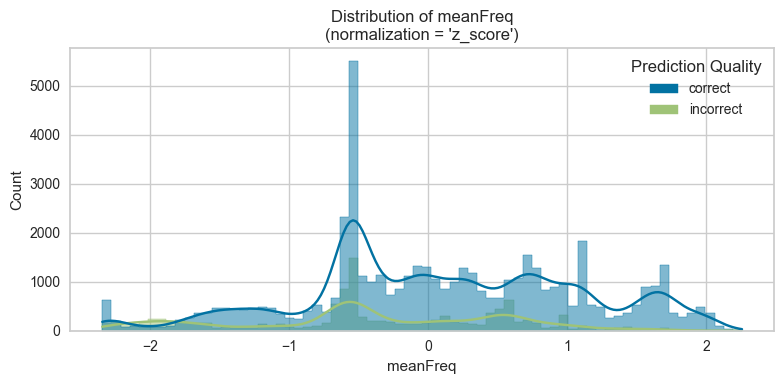

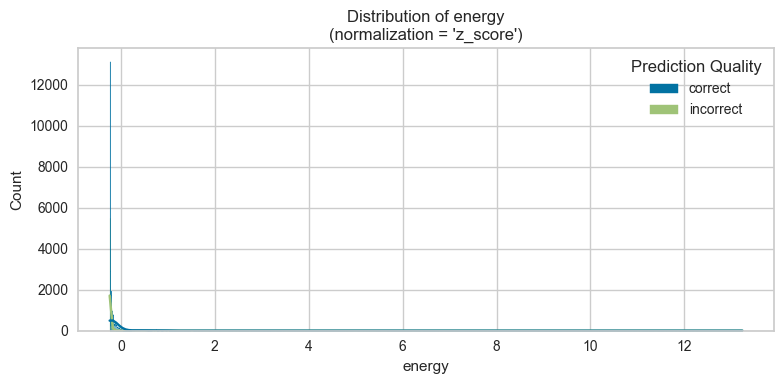

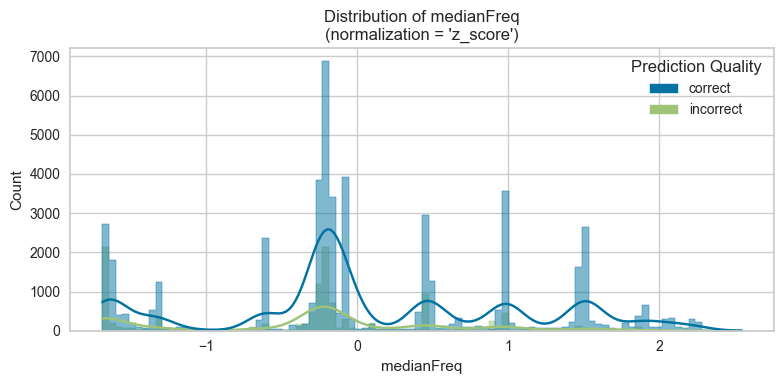

In [37]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [38]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [39]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [40]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,medianFreq,0.129819
1,meanWavelet,0.124213
2,std,0.113110
3,meanFreq,0.090736
4,rms,0.086484
5,energy,0.080824
6,entropyWavelet,0.068489
7,spectral_entropy,0.065901
8,varWavelet,0.063185
9,spectral_skewness,0.056401


In [42]:
add_top_features(rf_top_features, top_n=3)

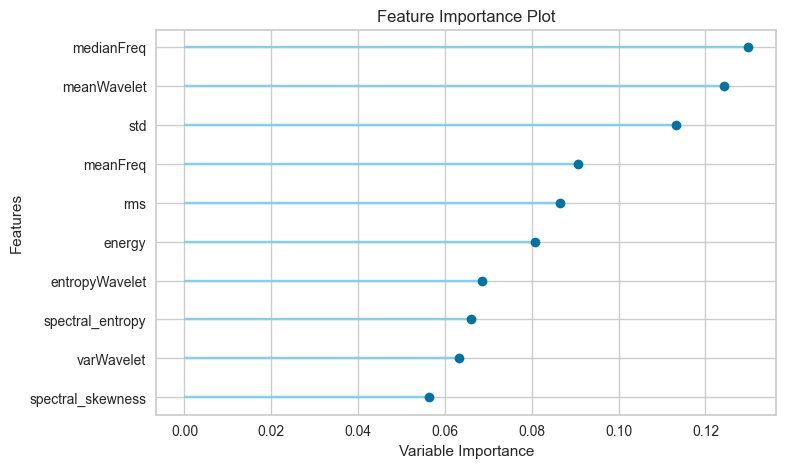

In [43]:
plot_model(rf, plot='feature')

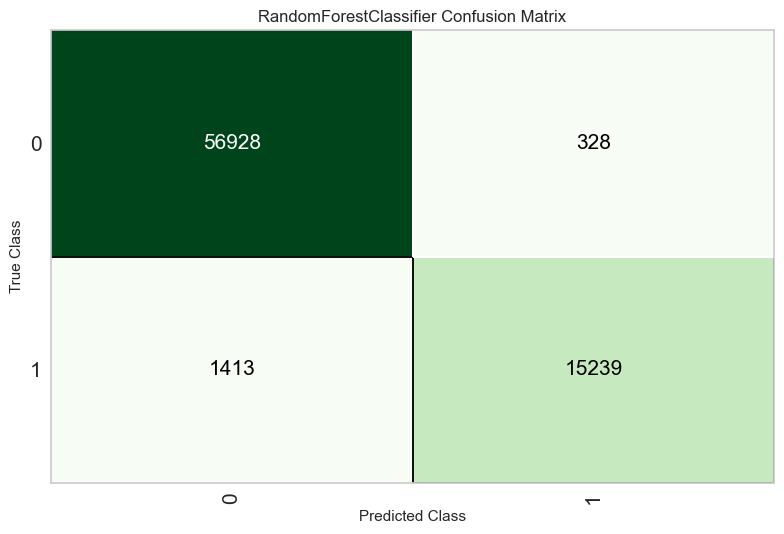

In [44]:
plot_model(rf, plot='confusion_matrix')

In [45]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9773,0.9954,0.9773,0.9773,0.9770,0.9333,0.9342,0.9557,0.0227,0.9008,0.0744


In [46]:
get_incorrect_predictions(predictions_rf)

,rms,std,varWavelet,crest,spectral_entropy,spectral_skewness,meanWavelet,entropyWavelet,entropySpectrogram,entropy,meanFreq,energy,medianFreq,Label,prediction_label,prediction_score
371,-0.589200,-0.621327,-0.276436,-0.137891,-0.482752,-0.413348,-0.715625,0.164535,-0.156183,0.181996,0.700811,-0.240687,1.582892,healthy,damaged,0.53
255446,-0.358185,-0.369122,-0.253325,0.507952,-0.401574,0.631687,-0.483033,0.177352,-0.155978,0.186205,-0.496433,-0.228531,-0.227242,healthy,damaged,0.78
208936,0.138583,0.173702,-0.113825,-0.433099,0.025951,0.133423,0.296737,0.200995,-0.151885,0.173318,-0.017250,-0.139794,-0.185029,healthy,damaged,0.68
202856,-0.143407,-0.134430,-0.212232,-0.042167,-0.249315,-1.618929,-0.090688,0.201269,-0.155564,0.186095,-0.437911,-0.200652,-0.204121,healthy,damaged,0.85
203984,-0.027065,-0.007291,-0.185189,-0.049058,-0.132951,-0.565889,0.141301,0.211028,-0.154812,0.183198,0.408944,-0.178880,-0.107278,healthy,damaged,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259550,-0.407416,-0.422818,-0.262243,0.402406,-0.425695,-0.251262,-0.500248,0.176113,-0.156119,0.185716,-0.537123,-0.232671,-0.238221,healthy,damaged,0.78
240598,-0.391927,-0.405950,-0.259031,0.223008,-0.419518,-0.086291,-0.513805,0.175550,-0.156074,0.185637,-0.506985,-0.231459,-0.216081,damaged,healthy,0.54
203710,-0.027546,-0.007810,-0.183022,-0.037907,-0.137945,-0.643991,0.121655,0.209357,-0.154807,0.183048,0.267987,-0.178980,-0.167585,healthy,damaged,0.58
206916,-0.158916,-0.151280,-0.216526,-0.347732,-0.243822,-0.806572,-0.109464,0.200570,-0.155599,0.187132,-0.605074,-0.203200,-0.276549,healthy,damaged,0.75


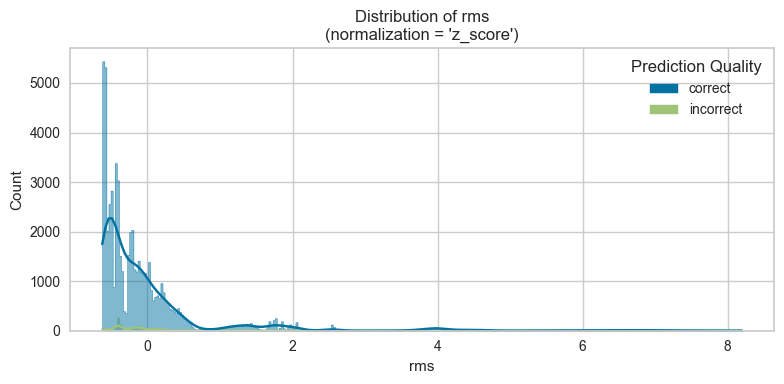

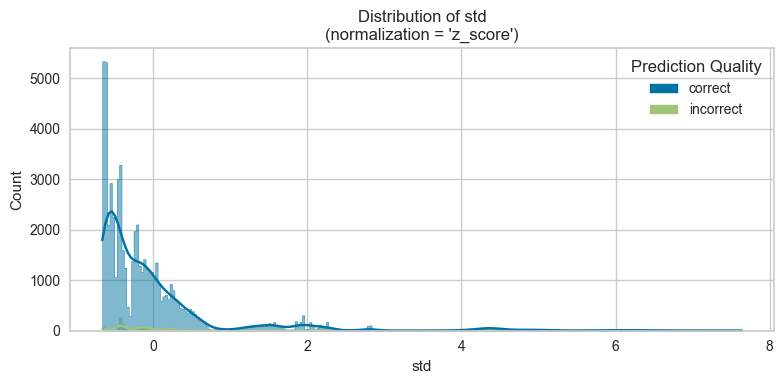

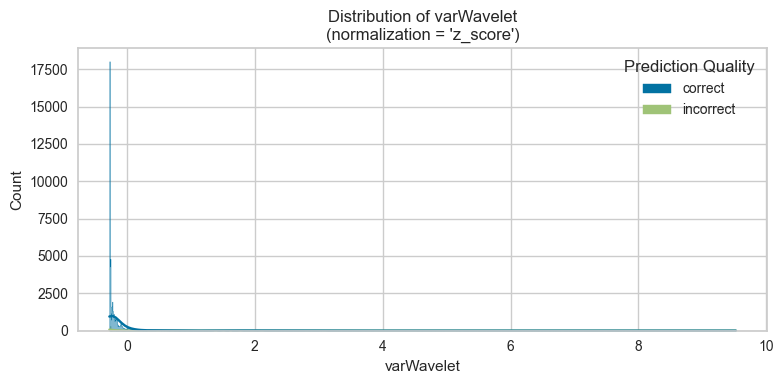

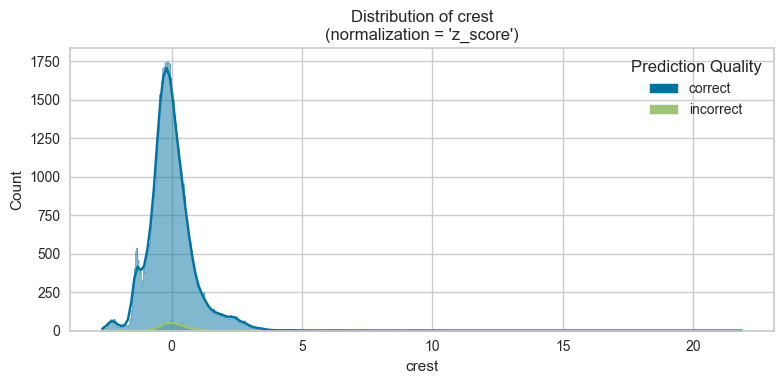

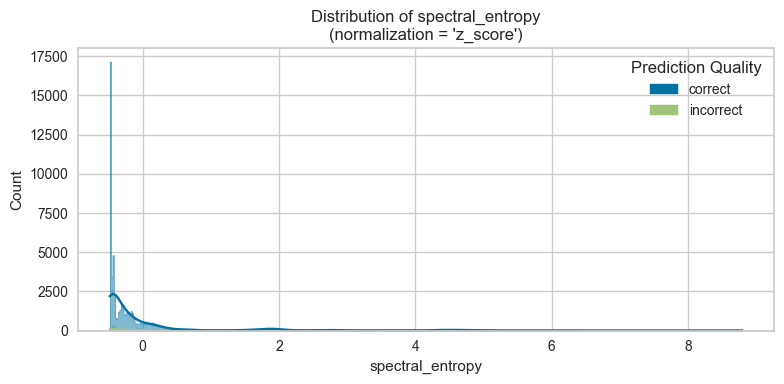

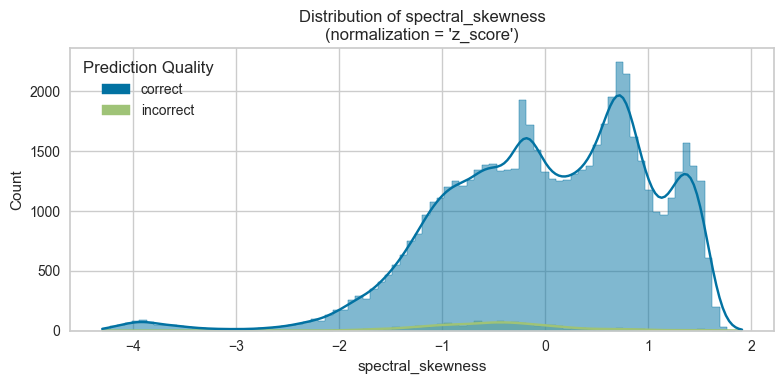

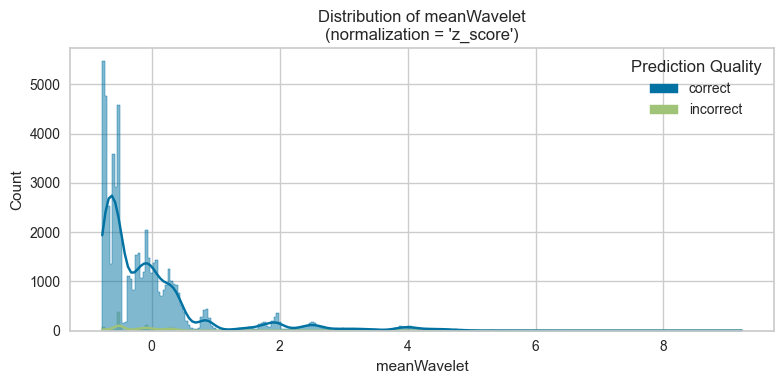

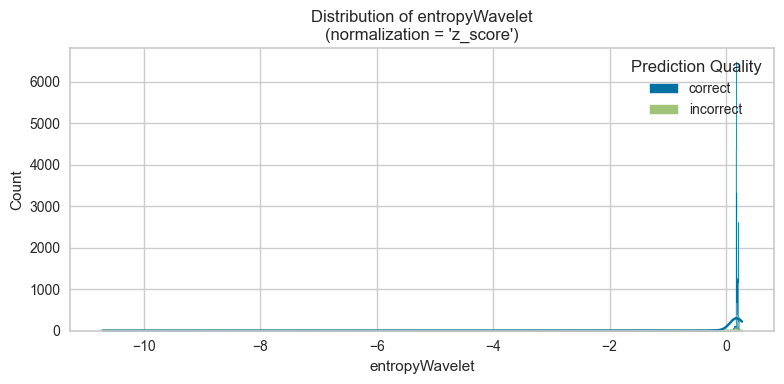

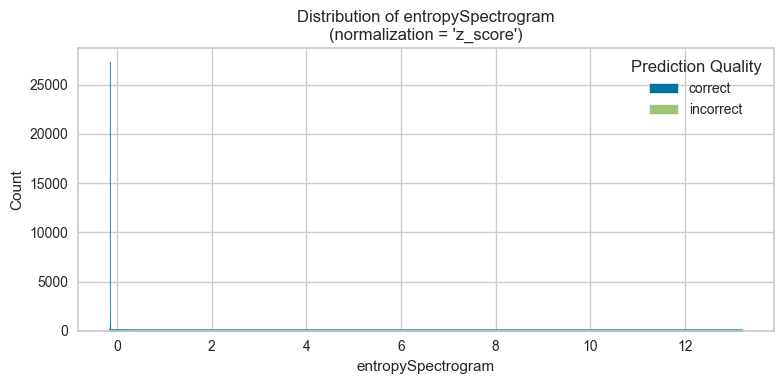

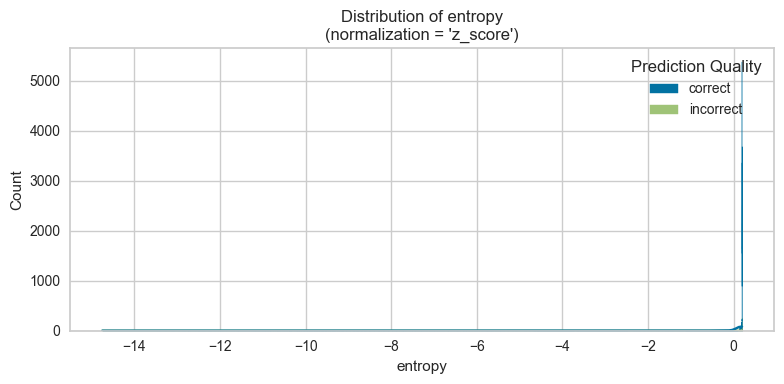

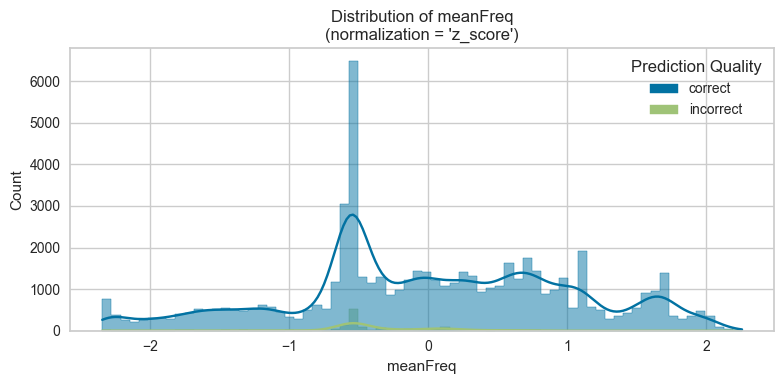

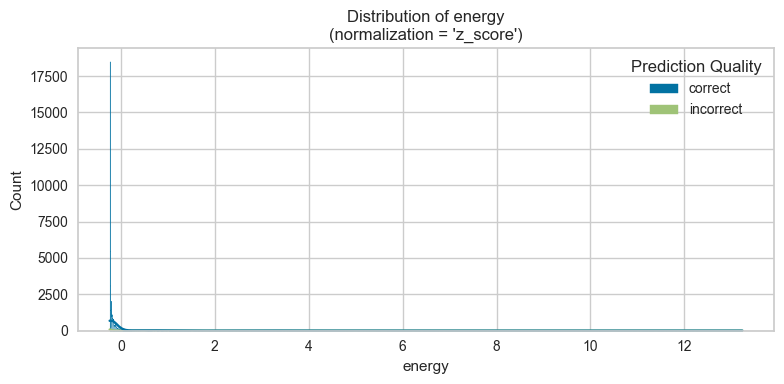

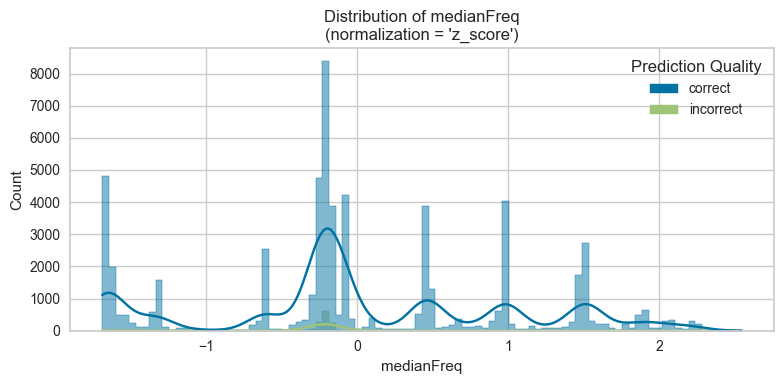

In [47]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [48]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [49]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [50]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

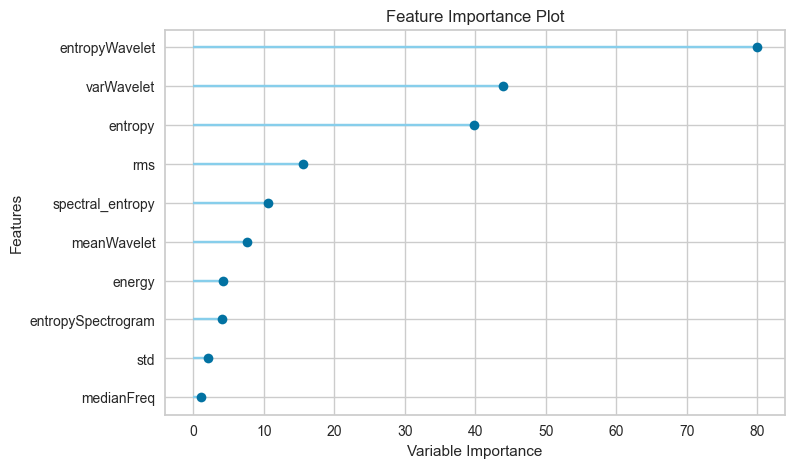

In [51]:
plot_model(svm, plot='feature')

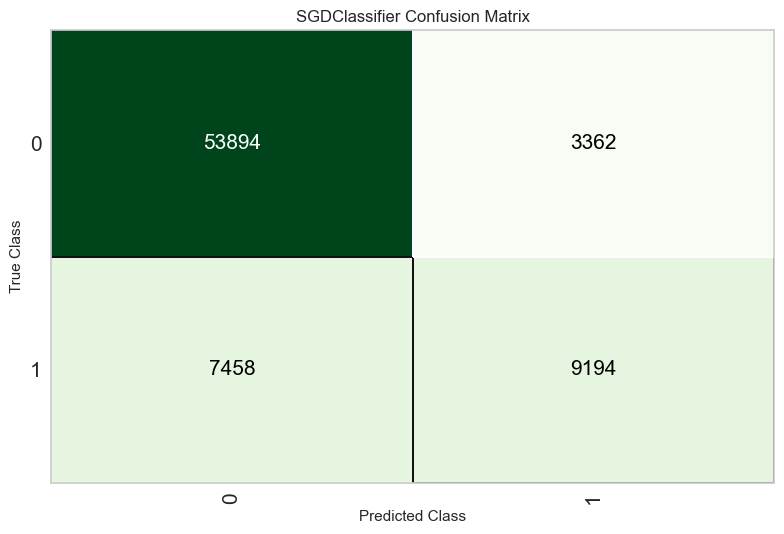

In [52]:
plot_model(svm, plot='confusion_matrix')

In [53]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8591,0,0.8591,0.8518,0.8519,0.5593,0.5673,0.7560,0.1409,0.4762,0


In [54]:
get_incorrect_predictions(predictions_svm)

,rms,std,varWavelet,crest,spectral_entropy,spectral_skewness,meanWavelet,entropyWavelet,entropySpectrogram,entropy,meanFreq,energy,medianFreq,Label,prediction_label
261113,-0.036985,-0.018097,-0.182138,-0.201324,-0.139669,-1.171345,0.075207,0.209378,-0.154960,0.183979,-0.556726,-0.180919,-0.226035,healthy,damaged
207745,-0.054912,-0.037686,-0.178280,-0.817718,-0.195269,0.691030,-0.053889,0.195415,-0.154350,0.185946,-0.305068,-0.184518,-0.192099,healthy,damaged
255723,-0.187058,-0.182074,-0.222601,-0.400318,-0.276949,-1.011019,-0.162859,0.196681,-0.155770,0.187372,-0.329926,-0.207612,-0.160991,healthy,damaged
207040,-0.082632,-0.067949,-0.195858,0.134858,-0.175329,-0.560391,0.005402,0.206877,-0.155277,0.184664,-0.596088,-0.189864,-0.220380,healthy,damaged
254381,-0.395739,-0.410098,-0.259882,0.060705,-0.424873,-0.587448,-0.508877,0.175432,-0.156080,0.185486,-0.556680,-0.231765,-0.237748,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6607,-0.482263,-0.504485,-0.270283,-1.490078,-0.462917,1.119532,-0.604374,0.170918,-0.156173,0.184481,0.953232,-0.237358,0.882884,healthy,damaged
19837,-0.499058,-0.522852,-0.271782,-0.447340,-0.467440,-0.147879,-0.621616,0.169476,-0.156176,0.183886,1.536079,-0.238143,1.492756,healthy,damaged
100049,-0.613250,-0.648307,-0.276743,-0.345024,-0.484380,0.936121,-0.752595,0.163765,-0.156183,0.181730,-1.000685,-0.240891,-1.631556,damaged,healthy
205706,-0.426794,-0.444088,-0.264963,0.161131,-0.430282,-0.102287,-0.516059,0.174827,-0.156138,0.185292,-0.531057,-0.234071,-0.213101,healthy,damaged


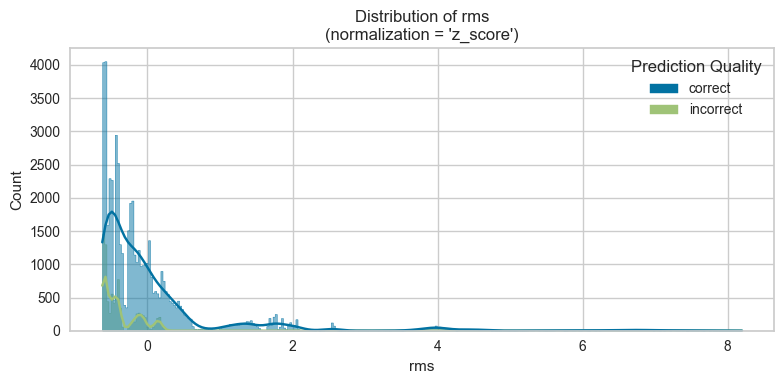

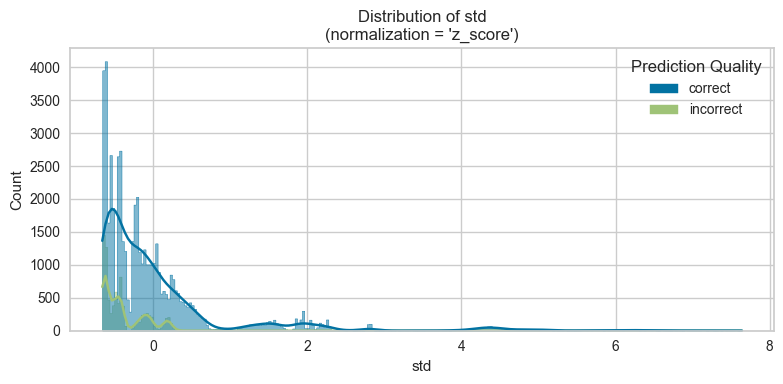

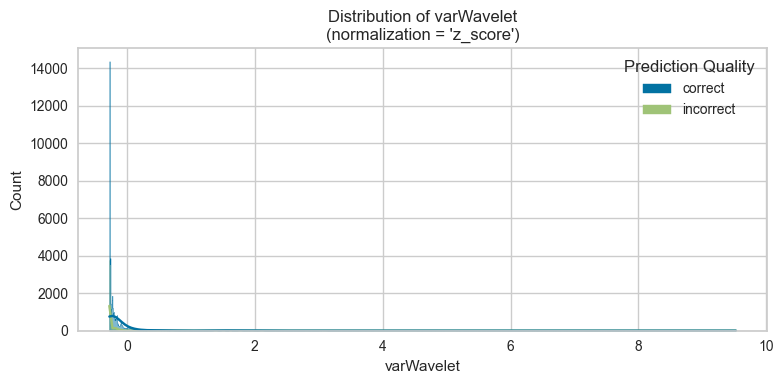

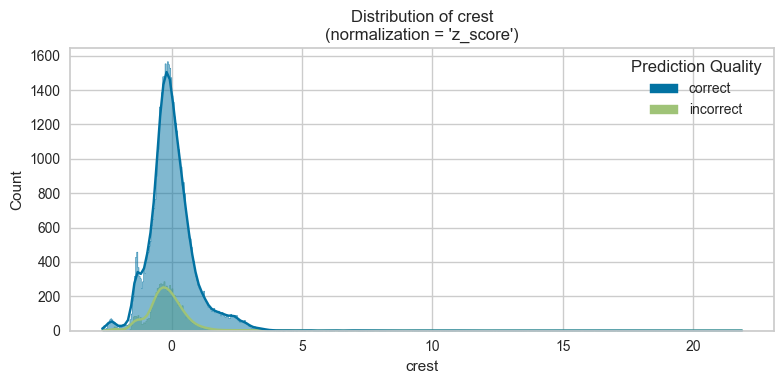

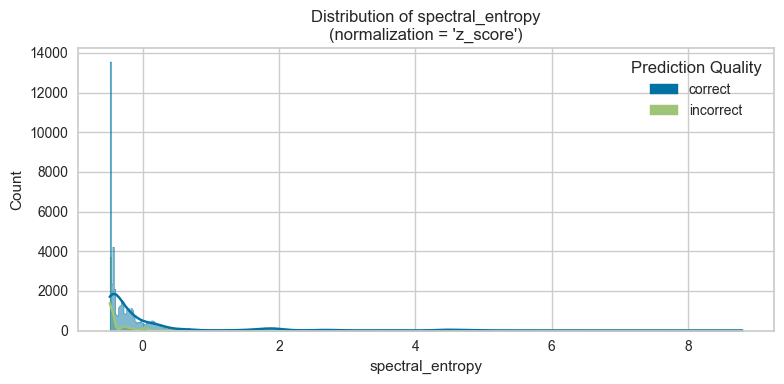

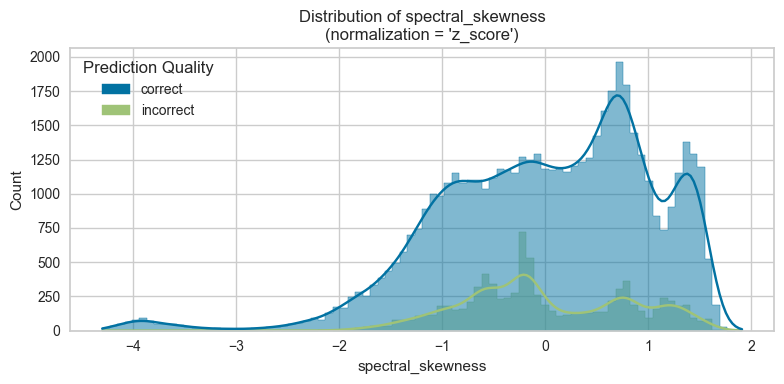

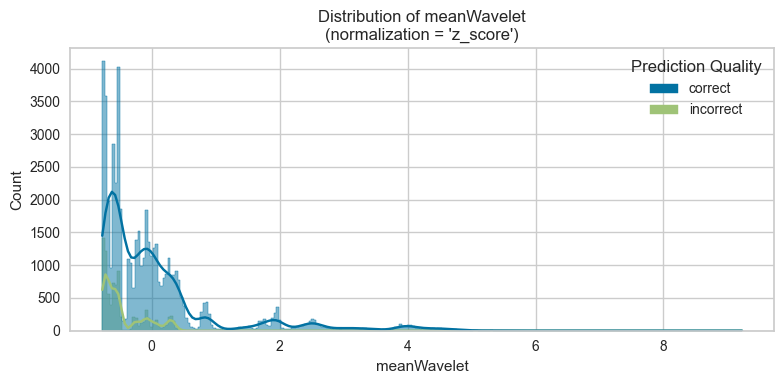

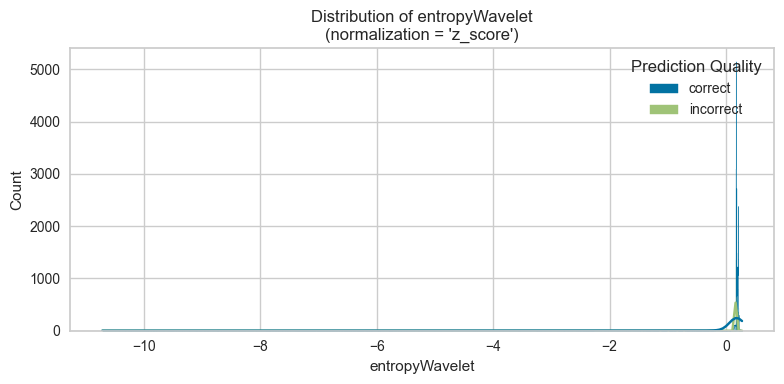

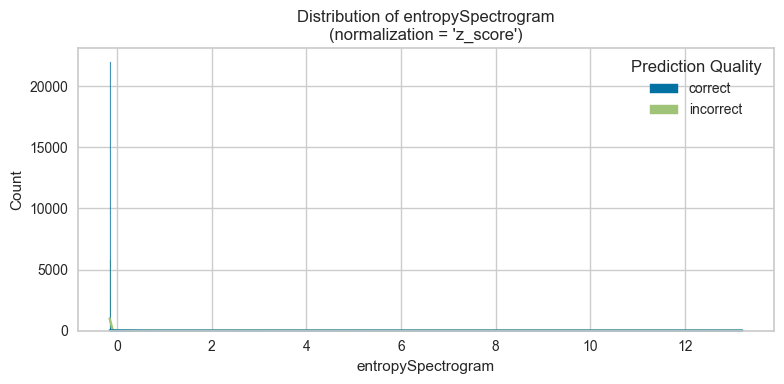

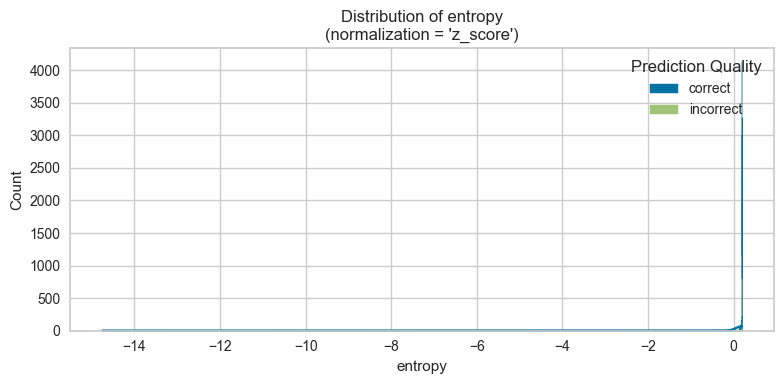

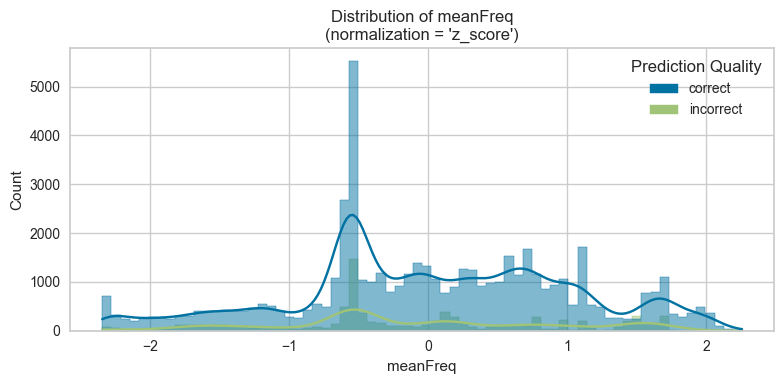

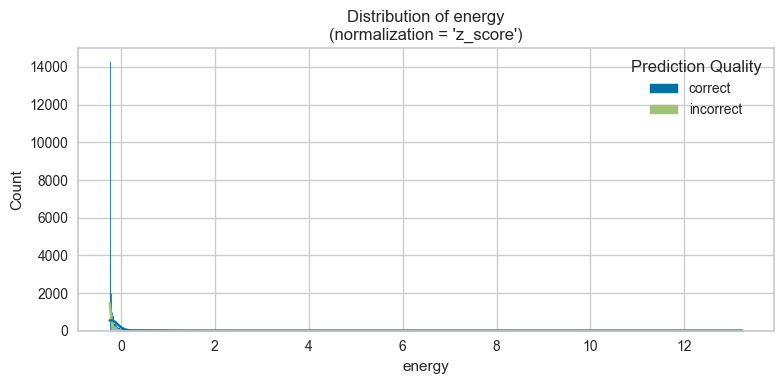

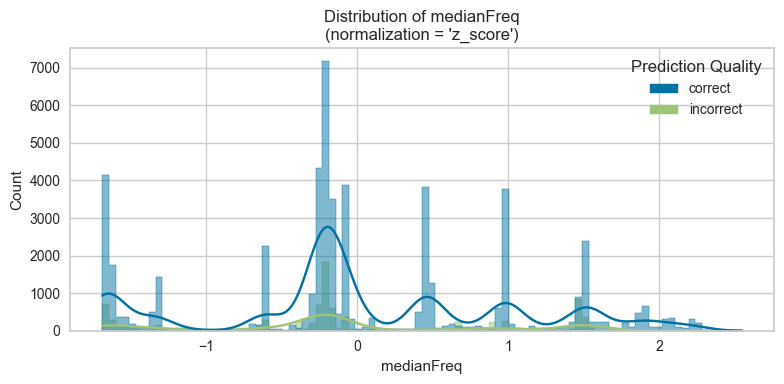

In [55]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [56]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (197087, 14) | Val Shape: (49272, 14) | Test Shape: (61590, 14)


In [57]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [58]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['rms', 'std', 'varWavelet', 'crest', 'spectral_entropy', 'spectral_skewness', 'meanWavelet', 'entropyWavelet', 'entropySpectrogram', 'entropy', 'meanFreq', 'energy', 'medianFreq']


In [59]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [60]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [61]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [62]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [63]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-07 17:13:47,530 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [64]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 17:13:47,591 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 17:13:47,617 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 17:13:47,739 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-07 17:13:47,844 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 17:13:47,888 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  121 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 121 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-07 17:25:16,240 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 17:25:16,244 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [65]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9261893033981323     │
│        test_auroc         │    0.9642804265022278     │
│     test_cohen_kappa      │    0.7651509642601013     │
│       test_f1_score       │    0.9261893033981323     │
│   test_hamming_distance   │    0.07381068170070648    │
│    test_jaccard_index     │    0.7973276376724243     │
│         test_loss         │    0.18541741371154785    │
│        test_loss_0        │    0.18541741371154785    │
│  test_matthews_corrcoef   │     0.780168890953064     │
│      test_precision       │    0.9261893033981323     │
│        test_recall        │    0.9261893033981323     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [66]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [67]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-07 17:25:35,854 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [68]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 17:25:35,901 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 17:25:35,935 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 17:25:36,064 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-07 17:25:36,147 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 17:25:36,181 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  8.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     30 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 8.6 K                                                                                            
Non-trainable params: 8                                                                                            
Total params: 8.6 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-07 17:35:20,020 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 17:35:20,030 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [69]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
93960,0.736629,0.263371,damaged
371,0.337339,0.662661,healthy
33266,0.461490,0.538510,healthy
238774,0.911150,0.088851,damaged
210317,0.763641,0.236359,damaged
16,0.548506,0.451494,damaged
117119,0.694789,0.305211,damaged
258524,0.711939,0.288061,damaged
226017,0.921406,0.078594,damaged
6208,0.485633,0.514367,healthy


In [70]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8533365726470947     │
│        test_auroc         │    0.8391786813735962     │
│     test_cohen_kappa      │    0.5353211164474487     │
│       test_f1_score       │    0.8533365726470947     │
│   test_hamming_distance   │    0.14666341245174408    │
│    test_jaccard_index     │    0.6442286968231201     │
│         test_loss         │    0.39149028062820435    │
│        test_loss_0        │    0.39149028062820435    │
│  test_matthews_corrcoef   │    0.5459284782409668     │
│      test_precision       │    0.8533365726470947     │
│        test_recall        │    0.8533365726470947     │
└───────────────────────────┴───────────────────────────┘

In [71]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
12,medianFreq,1.458637
11,energy,0.875131
1,std,0.856094
5,spectral_skewness,0.627475
6,meanWavelet,0.612216
0,rms,0.565490
2,varWavelet,0.552586
3,crest,0.544474
4,spectral_entropy,0.519336
8,entropySpectrogram,0.431253


In [72]:
add_top_features(gandalf_top_features, top_n=3)

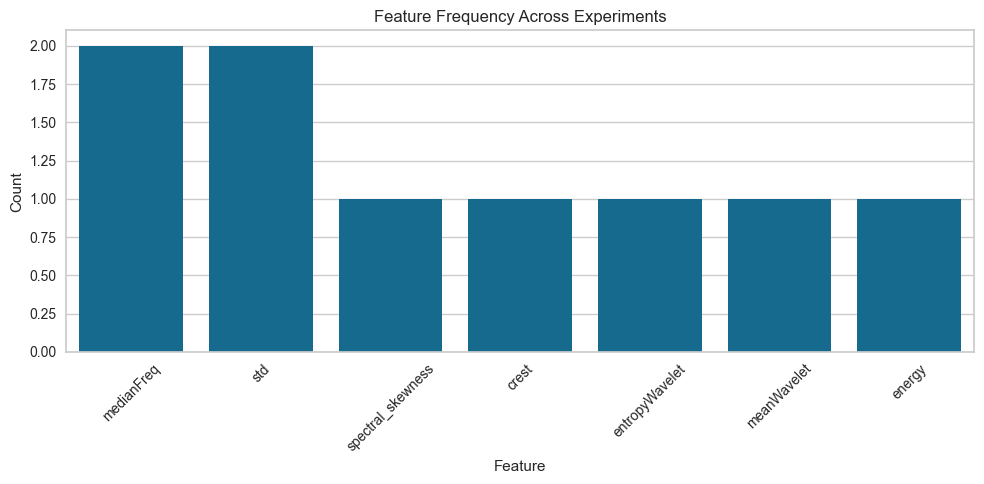

In [73]:
plot_feature_importance()